# Transformer model for a Text Generation task
## Generate product names from a long description text on the product

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/transformer_chatbot.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/community/en/transformer_chatbot.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial is inspired in a Tensorfow tutorial:https://medium.com/tensorflow/a-transformer-chatbot-tutorial-with-tensorflow-2-0-88bf59e66fe2

In this demo we train a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to generate a product name from a description text. This is an advanced example that assumes knowledge of [text generation](https://tensorflow.org/alpha/tutorials/text/text_generation), [attention](https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention) and [transformer](https://www.tensorflow.org/alpha/tutorials/text/transformer).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

**Note**: The model architecture is identical to the example in [Transformer model for language understanding](https://www.tensorflow.org/alpha/tutorials/text/transformer), and we demonstrate how to implement the same model in the Functional approach instead of Subclassing.

## Loading the libraries

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')

!pip install tensorflow-datasets==1.2.0
import tensorflow_datasets as tfds
# To use Word tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import os
import re
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from google.colab import drive

     |████████████████████████████████| 2.3MB 10.8MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


## Load the packages for the metric Rouge Score

In [ ]:
#!pip install datasets
#!pip install rouge_score

In [ ]:
#import datasets

We set a initial seed to reproduce results in future experiments

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define some global parameters

Next we create variables to locate the datasets. If you want to try it yourself, change theses values:

In [ ]:
# Parameters for our model
INPUT_COLUMN = 'description'
TARGET_COLUMN = 'name'
NUM_SAMPLES = 31000 #40000
MAX_VOCAB_SIZE = 2**10

BATCH_SIZE = 32  # Batch size for training.
EPOCHS = 5  # Number of epochs to train for.
TEXT_MAX_LENGTH = 115 #If Word Tokenizer ->50
SUMM_MAX_LENGTH= 25 #If Word Tokenizer ->7

# Global parameters
root_folder='/content/drive'
data_folder_name='My Drive/datasets/text_gen_product_names'
model_folder_name='My Drive/Projects/text_generation_names/model/'
checkpoint_folder = "My Drive/Projects/text_generation_names/ckpt/"
output_folder = "My Drive/Projects/text_generation_names/output/"
# Set the train and test filenames
train_filename='cl_stopw_train.csv'
test_filename='cl_stopw_test_descriptions.csv'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))
test_filenamepath = os.path.abspath(os.path.join(DATA_PATH, test_filename))
checkpoint_path = os.path.abspath(os.path.join(root_folder, checkpoint_folder+'ckpt_transformer'))
model_path = os.path.abspath(os.path.join(root_folder, model_folder_name))
output_path = os.path.abspath(os.path.join(root_folder, output_folder))

# Both train and test set are in the root data directory
train_path = DATA_PATH
# Seed
train_frac=0.9
OOV_TOKEN='<unk>'
# Select the type of tokenizer word or subword
type_tokenizer='subword'
share_vocab=True

##Prepare Dataset

We will use a dataset with about 30.000 samples, each sample contains a feature text, a long and descriptive text of a item or product (a piece of cloth) and the label, a short text, the proposal for the product name.


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Before training, we usually neeed to clean and preprocess the text data. In this case, it is very simple: remove html tags, punctuations (except basic ones .,?).

And we do not want to split or break some commom prefixes like Mr., Ms.,..., we have a list of them and we avoid to "process" them.

In [ ]:
# Remove html tag
def remove_html(text):
    ''' Remove HTML tags from the text'''
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def preprocess_sentence(sentence):
  sentence = remove_html(sentence)
  sentence = str(sentence).lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  return sentence

def preprocess_text_nonbreaking(corpus, non_breaking_prefixes):
  corpus_cleaned = preprocess_sentence(corpus)
  # Add the string $$$ before the non breaking prefixes
  # To avoid remove dots from some words
  for prefix in non_breaking_prefixes:
    corpus_cleaned = corpus_cleaned.replace(prefix, prefix + '$$$')
  # Remove dots not at the end of a sentence
  corpus_cleaned = re.sub(r"\.(?=[0-9]|[a-z]|[A-Z])", ".$$$", corpus_cleaned)
  # Remove the $$$ mark
  corpus_cleaned = re.sub(r"\.\$\$\$", '', corpus_cleaned)
  # Rmove multiple white spaces
  corpus_cleaned = re.sub(r"  +", " ", corpus_cleaned)

  return corpus_cleaned

with open(DATA_PATH+"/nonbreaking_prefix.en", 
          mode = "r", encoding = "utf-8") as f:
    non_breaking_prefix_en = f.read()

non_breaking_prefix_en = non_breaking_prefix_en.split("\n")
non_breaking_prefix_en = [' ' + pref + '.' for pref in non_breaking_prefix_en]

### Load and preprocess data
First, we read the train dataset from a CSV file to a pandas Dataframe.


In [ ]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_filenamepath, header=0, usecols=[0,1], 
               nrows=NUM_SAMPLES)
print('Num Examples: ',len(df))
print('Null Values\n', df.isna().sum())

Num Examples:  31000
Null Values
 name           2
description    1
dtype: int64


Remove rows with null values: 

In [ ]:
df.dropna(inplace=True)
print('Num Examples: ',len(df))

Num Examples:  30997


Then, we preprocess the text data and show the count of samples and show some of them:

In [ ]:
# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_text_nonbreaking(x, non_breaking_prefix_en)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_text_nonbreaking(x, non_breaking_prefix_en)).tolist()

print('Number of sentences: ',len(input_data),' - ', len(target_data))
print(input_data[:5])
print(target_data[:5])

Number of sentences:  30997  -  30997
['twopiece set . short sleeve tshirt featuring round neck snapbutton fastening shoulder dinosaur print . shorts featuring elastic waistband front pockets .', 'tshirt round neckline short sleeves front patch pocket .', 'zara edt . . . oriental eau toilette . scent reveals notes bergamot cardamom sandalwood . warm intense modern fragrance . item must returned original packaging intact .', 'swimming trunks elastic drawstring waistband . side pockets rear patch pocket flap . lining .', 'short sleeve tshirt round neckline .']
['plush jersey dinosaur set', 'fadedeffect tshirt trf', '', 'geometric print swimming trunks', 'basic cotton tshirt trf']


In [ ]:
df.describe()

,name,description
count,30997,30997
unique,21827,28961
top,printed dress,short sleeve tshirt round neckline front print .
freq,58,46


In [ ]:
print('Sample description: {}'.format(input_data[20]))
print('Sample name: {}'.format(target_data[20]))

Sample description: round neck dress long sleeves . softtouch ribbed fabric contrast tulle polka dots .
Sample name: contrast tulle dress


##Tokenization


In this section we tokenize our text data, as you may know, we need to transform text to numbers using a tokenizer: 
* Build tokenizer (map text to ID and ID to text) using [TensorFlow Datasets SubwordTextEncoder](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder) or using a Word tokenizer with fits_on_texts.
* Tokenize each sentence and add `START_TOKEN` and `END_TOKEN` to indicate the start and end of each sentence.
* Filter out sentence that has more than `MAX_LENGTH` tokens.
* Pad tokenized sentences to `MAX_LENGTH`


In [ ]:
# Tokenize, filter and pad sentences using SubwordTextencoder
def tokenize_and_filter(inputs, outputs, input_max_len, output_max_len):
  tokenized_inputs, tokenized_outputs = [], []
  max_inp_len=0
  max_out_len=0

  for (sentence1, sentence2) in zip(inputs, outputs):
    # tokenize sentence
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    # check max lenthg
    if len(sentence1)> max_inp_len:
        max_inp_len = len(sentence1)
    if len(sentence2)> max_out_len:
        max_out_len = len(sentence2)
       
    # check tokenized sentence max length
    if len(sentence1) < input_max_len and len(sentence2) < output_max_len:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
      
  print('Max input length: ', max_inp_len,'Max output length: ', max_out_len)
  # pad tokenized sentences
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=input_max_len, truncating='post', padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=output_max_len, truncating='post', padding='post')
  
  return tokenized_inputs, tokenized_outputs
# Tokenize, filter and pad sentences using Word Tokenizer
def word_tokenize(input_data, max_vocab_size, max_length=None, OOV_token= None, 
                  filters='', padding= True):
    tokenizer = Tokenizer(num_words=max_vocab_size, filters=filters, oov_token=OOV_token)
    tokenizer.fit_on_texts(input_data)
    # Tokenize and transform input texts to sequence of integers
    input_sequences = tokenizer.texts_to_sequences(input_data)
    # Claculate the max length
    input_max_len = max(len(s) for s in input_sequences)
    # Apply padding and truncate if required
    if padding:
        if max_length != None:
            input_sequences = pad_sequences(input_sequences, maxlen=max_length, 
                                            truncating='post', padding='post')
        else:
            input_sequences = pad_sequences(input_sequences, padding='post')

    return input_sequences, tokenizer, input_max_len


If we want to apply a Subword toknizer, set type_tokenizer to `subword` or for a word tokenizer change the value to `word`. And run the next cells:

In [ ]:
if type_tokenizer == 'subword':
    # Build tokenizer using tfds for both questions and answers
    tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
        input_data + target_data, target_vocab_size=MAX_VOCAB_SIZE)

    # Define start and end token to indicate the start and end of a sentence
    START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

    # Vocabulary size plus start and end token
    VOCAB_SIZE = tokenizer.vocab_size + 2
    print('Tokenized sample text: {}'.format(tokenizer.encode(input_data[20])))
    print('Tokenized sample summary: {}'.format(tokenizer.encode(target_data[20])))

    
    encoder_inputs, decoder_outputs = tokenize_and_filter(input_data, target_data, 
                                                      TEXT_MAX_LENGTH, SUMM_MAX_LENGTH) 

    #Set the start and end token for input and output vocabulary
    sos_token_input = START_TOKEN
    eos_token_input = END_TOKEN
    sos_token_output = START_TOKEN
    eos_token_output = END_TOKEN
    print('Token for sos and eos:', sos_token_input, eos_token_input, sos_token_output, eos_token_output)
    num_words_inputs = VOCAB_SIZE
    num_words_output = VOCAB_SIZE
    print('Size of Input Vocabulary: ', num_words_inputs)
    print('Size of Output Vocabulary: ', num_words_output)

Tokenized sample text: [10, 29, 34, 6, 23, 1, 156, 691, 495, 72, 794, 73, 86, 27, 135, 112, 794, 675, 470, 877, 2]
Tokenized sample summary: [27, 135, 112, 794, 113]
Max input length:  585 Max output length:  32
Token for sos and eos: [1018] [1019] [1018] [1019]
Size of Input Vocabulary:  1020
Size of Output Vocabulary:  1020


If we want to tokenize based on words we use the Keras Tokenizer:

In [ ]:
if type_tokenizer == 'word':
    tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='', oov_token=OOV_TOKEN)
    # Insert the SOS and EOS token
    input_data = ['<start> '+inp+' <end>' for inp in input_data]
    target_data = ['<start> '+targ+' <end>' for targ in target_data]
    # Fit the tokenizer to the texts
    tokenizer.fit_on_texts(input_data)
    tokenizer.fit_on_texts(target_data)
    # Tokenize and transform input texts to sequence of integers
    input_sequences = tokenizer.texts_to_sequences(input_data)
    output_sequences = tokenizer.texts_to_sequences(target_data)
    # Claculate the max length
    input_max_length = max(len(s) for s in input_sequences)
    output_max_length = max(len(s) for s in output_sequences)
    print('Max input length: ', input_max_length)
    print('Max output length: ', output_max_length)
    # Apply padding and truncate if required
    encoder_inputs = pad_sequences(input_sequences, maxlen=TEXT_MAX_LENGTH, 
                                            truncating='post', padding='post')
    decoder_outputs = pad_sequences(output_sequences, maxlen=SUMM_MAX_LENGTH, 
                                            truncating='post', padding='post')

    #Set the start and end token for input and output vocabulary
    sos_token_input = tokenizer.word_index['<start>']
    eos_token_input = tokenizer.word_index['<end>']
    sos_token_output = tokenizer.word_index['<start>']
    eos_token_output = tokenizer.word_index['<end>']
    print('Token for sos and eos:', sos_token_input, eos_token_input, sos_token_output, eos_token_output)
    num_words_inputs = tokenizer.num_words
    num_words_output = tokenizer.num_words
    VOCAB_SIZE = tokenizer.num_words
    print('Size of Input Vocabulary: ', num_words_inputs)
    print('Size of Output Vocabulary: ', num_words_output)

Max input length:  252
Max output length:  17
Token for sos and eos: 2 3 2 3
Size of Input Vocabulary:  4096
Size of Output Vocabulary:  4096


In [ ]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of input samples: {}'.format(len(input_data)))
print('Number of output samples: {}'.format(len(target_data)))
print('Number of input samples: {}'.format(len(encoder_inputs)))
print('Number of output samples: {}'.format(len(decoder_outputs)))

Vocab size: 1020
Number of input samples: 30997
Number of output samples: 30997
Number of input samples: 30379
Number of output samples: 30379


### Create `tf.data.Dataset`

We are going to use the [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data) to contruct our input pipline in order to utilize features like caching and prefetching to speed up the training process.

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, self-attention allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peaking at the expected output the model uses a look-ahead mask.

Target is divided into `decoder_inputs` which padded as an input to the decoder and `cropped_targets` for calculating our loss and accuracy.

Splitting the dataset into a train and validation dataset:

In [ ]:
print(encoder_inputs.shape)
print(decoder_outputs.shape)

train_enc_inputs, val_enc_inputs, train_dec_outputs, val_dec_outputs, = train_test_split(encoder_inputs, decoder_outputs,
                                                                                       train_size=train_frac,random_state=SEED, shuffle=True )
print(train_enc_inputs.shape)
print(train_dec_outputs.shape)
print(val_enc_inputs.shape)
print(val_dec_outputs.shape)

(30379, 115)
(30379, 25)
(27341, 115)
(27341, 25)
(3038, 115)
(3038, 25)


Create a tf.data.Dataset for train and validation:

In [ ]:
BUFFER_SIZE = 20000

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_enc_inputs,
        'dec_inputs': train_dec_outputs[:, :-1]
    },
    {
        'outputs': train_dec_outputs[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': val_enc_inputs,
        'dec_inputs': val_dec_outputs[:, :-1]
    },
    {
        'outputs': val_dec_outputs[:, 1:]
    },
))

val_dataset = dataset.cache()
val_dataset = dataset.shuffle(BUFFER_SIZE)
val_dataset = dataset.batch(BATCH_SIZE)
val_dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(dataset)
print(val_dataset)

<PrefetchDataset shapes: ({inputs: (None, 115), dec_inputs: (None, 24)}, {outputs: (None, 24)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>
<PrefetchDataset shapes: ({inputs: (None, 115), dec_inputs: (None, 24)}, {outputs: (None, 24)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


## Attention Layer

*The next description and code cells are sections of the Tensorflow Tutorial*



### Scaled dot product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

As the softmax normalization is done on the `key`, its values decide the amount of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `query` and `key` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `query` and `key` should have a mean of 0 and variance of 1, so that we get a gentler softmax.

The mask is multiplied with *-1e9 (close to negative infinity).* This is done because the mask is summed with the scaled matrix multiplication of `query` and `key` and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

### Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, `query`, `key`, and `value` are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

## Transformer

### Masking



`create_padding_mask` and `create_look_ahead` are helper functions to creating masks to mask out padded tokens, we are going to use these helper functions as `tf.keras.layers.Lambda` layers.

Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

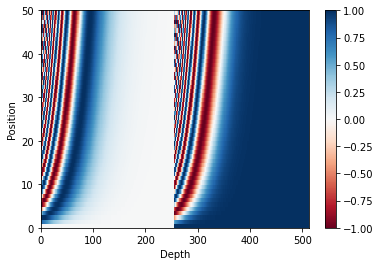

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask) 
2. 2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

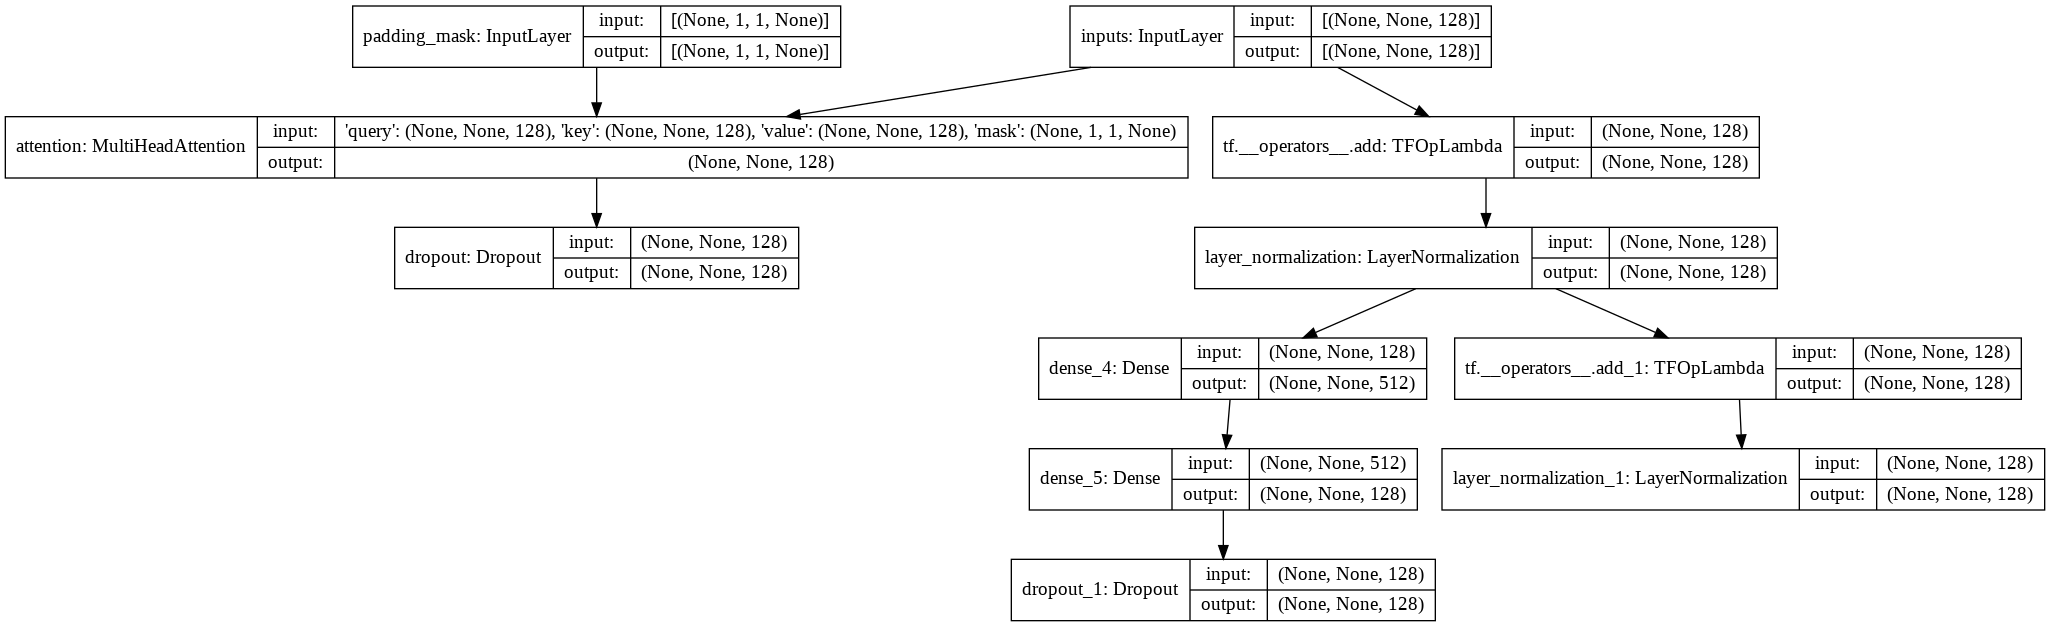

In [ ]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

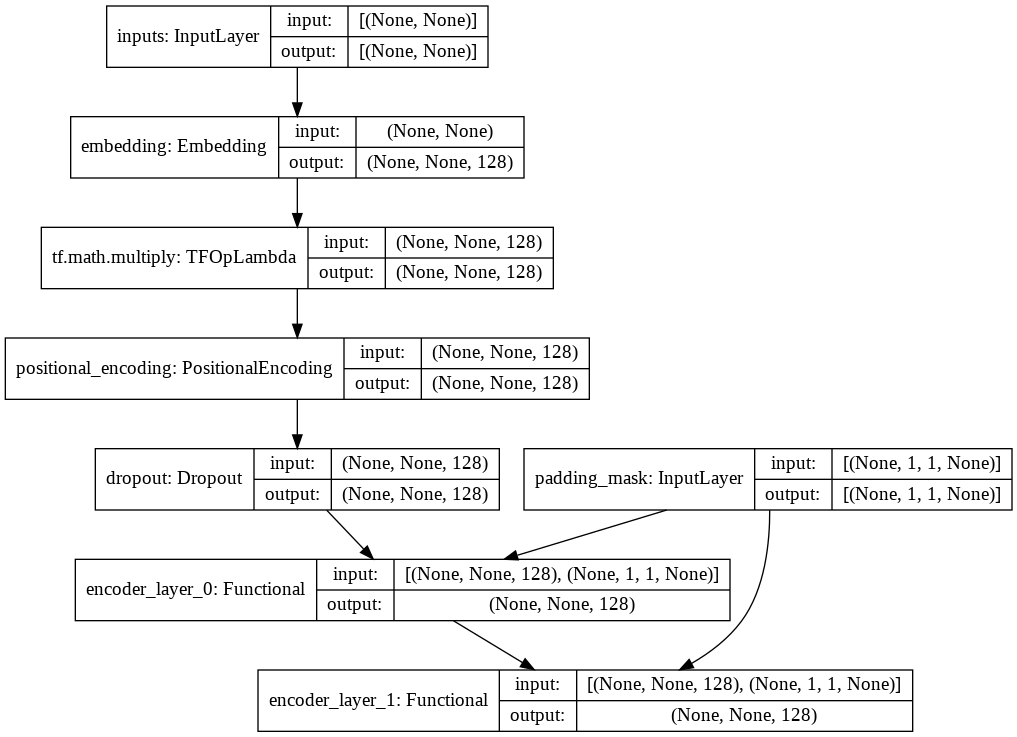

In [ ]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

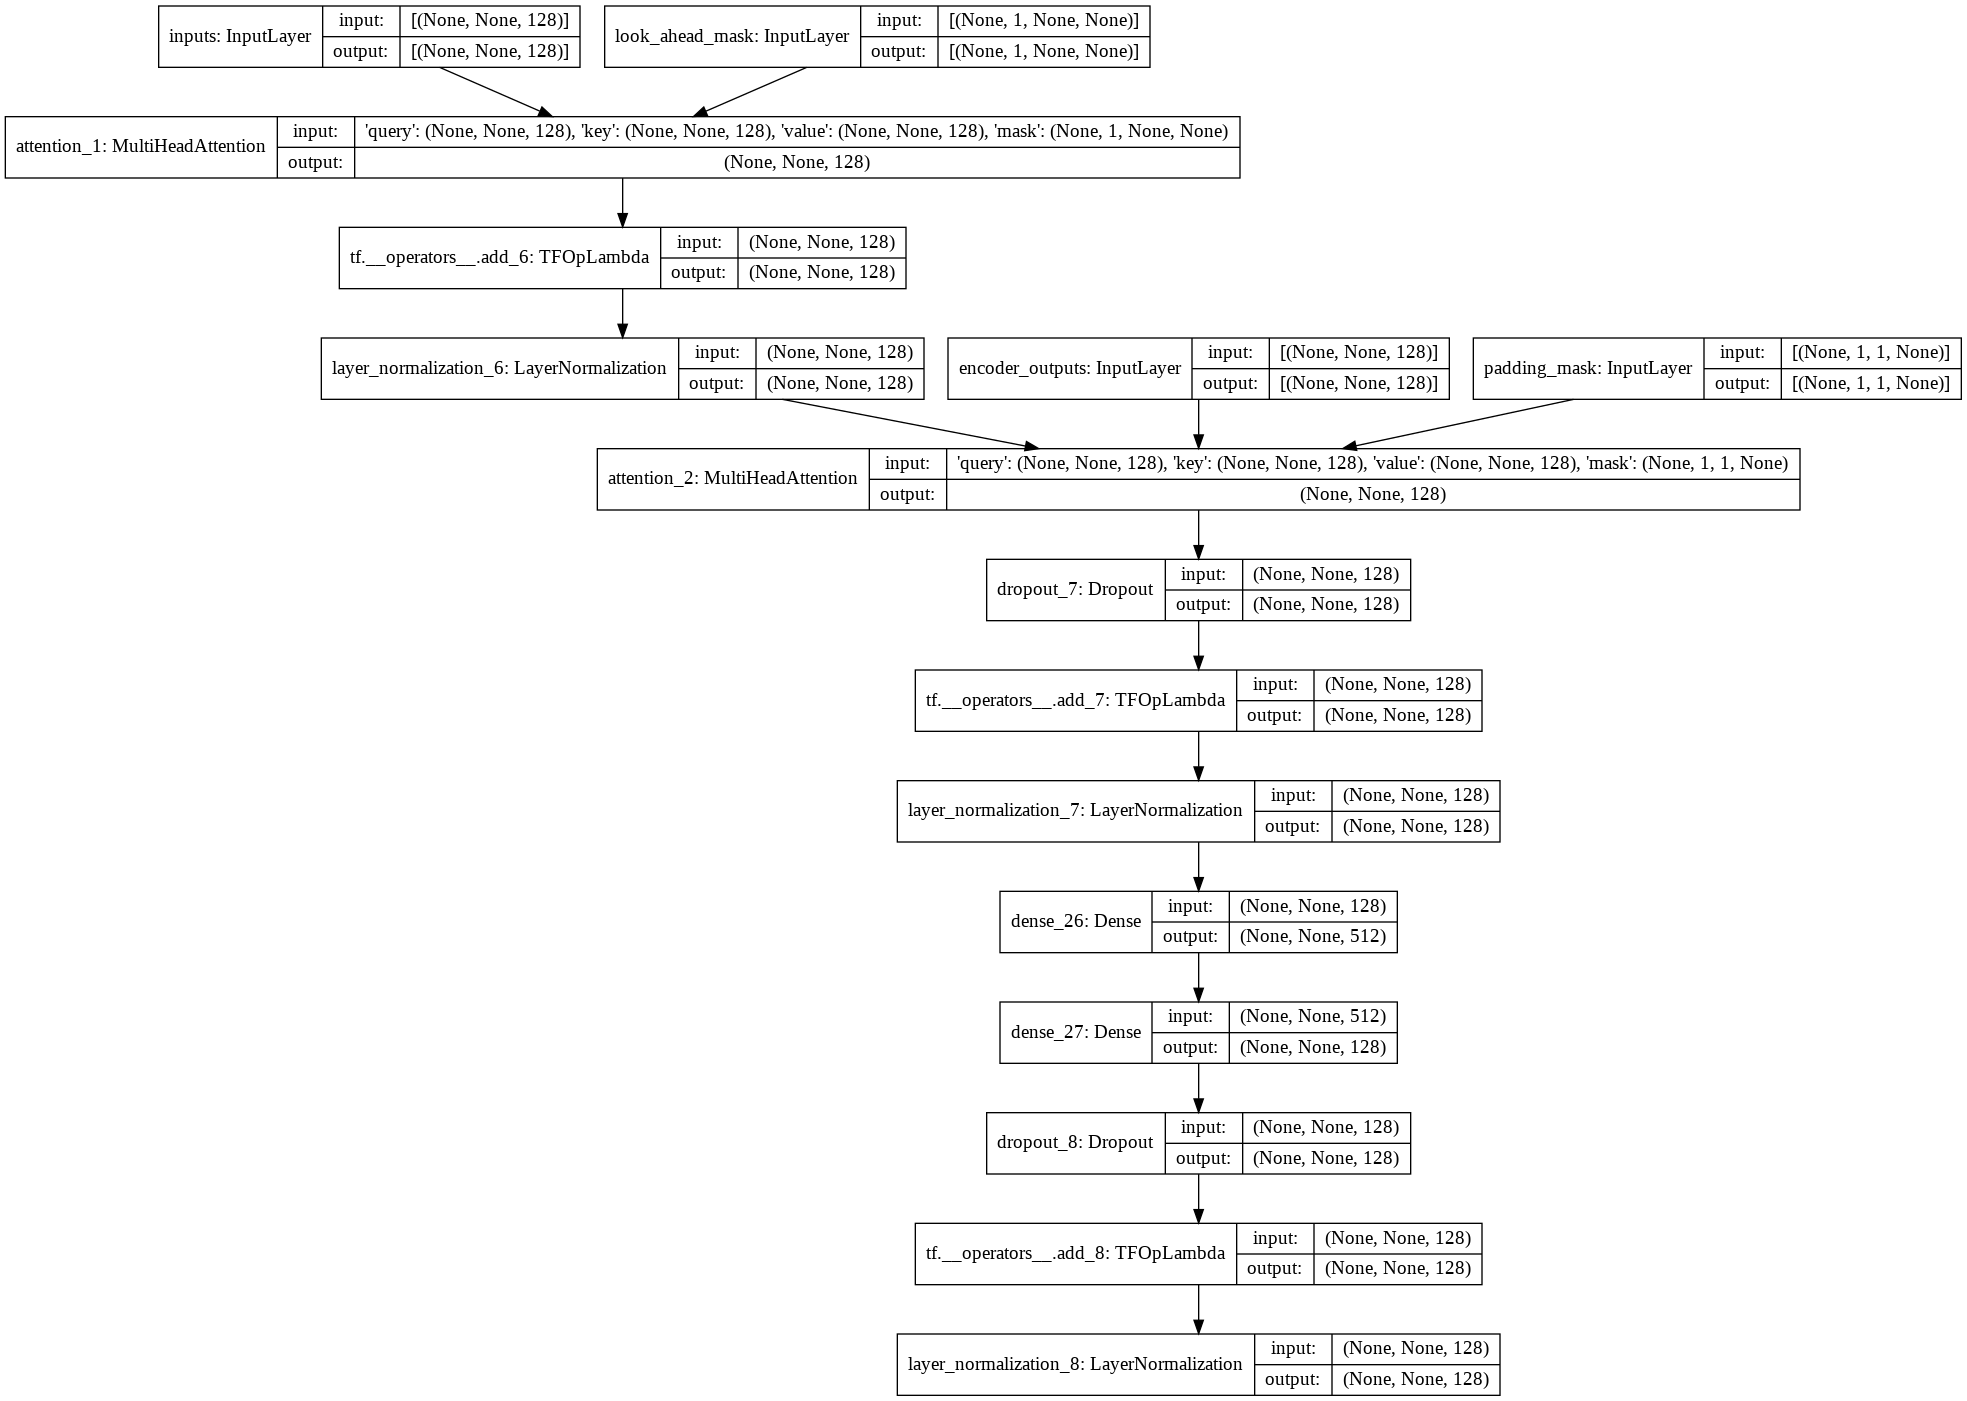

In [ ]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

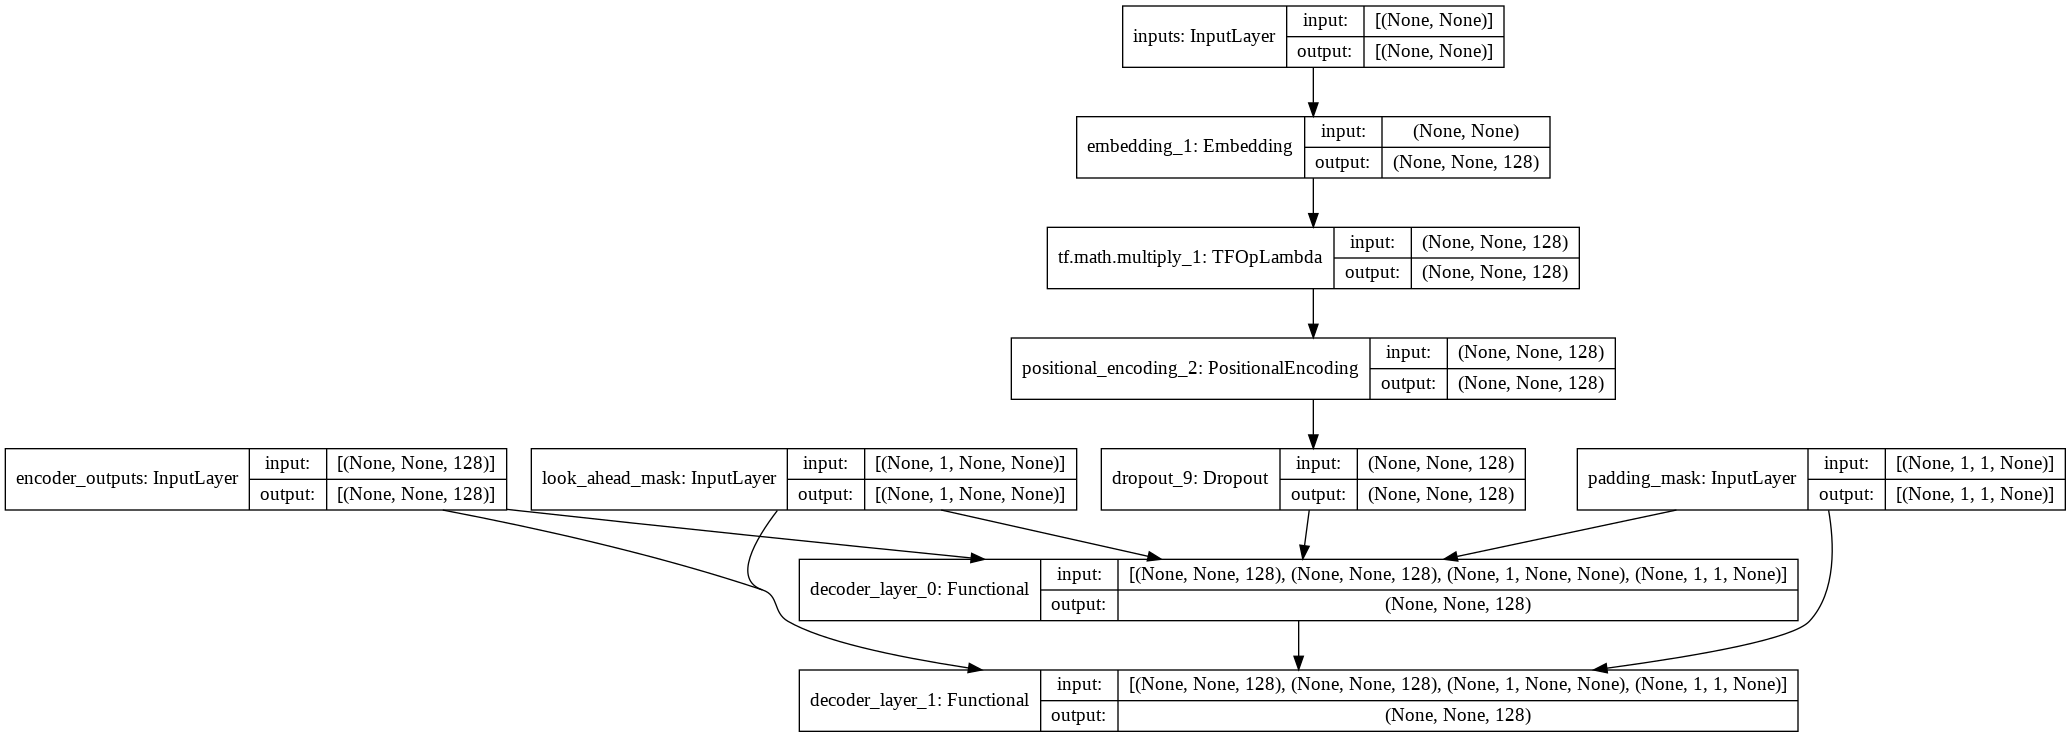

In [ ]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

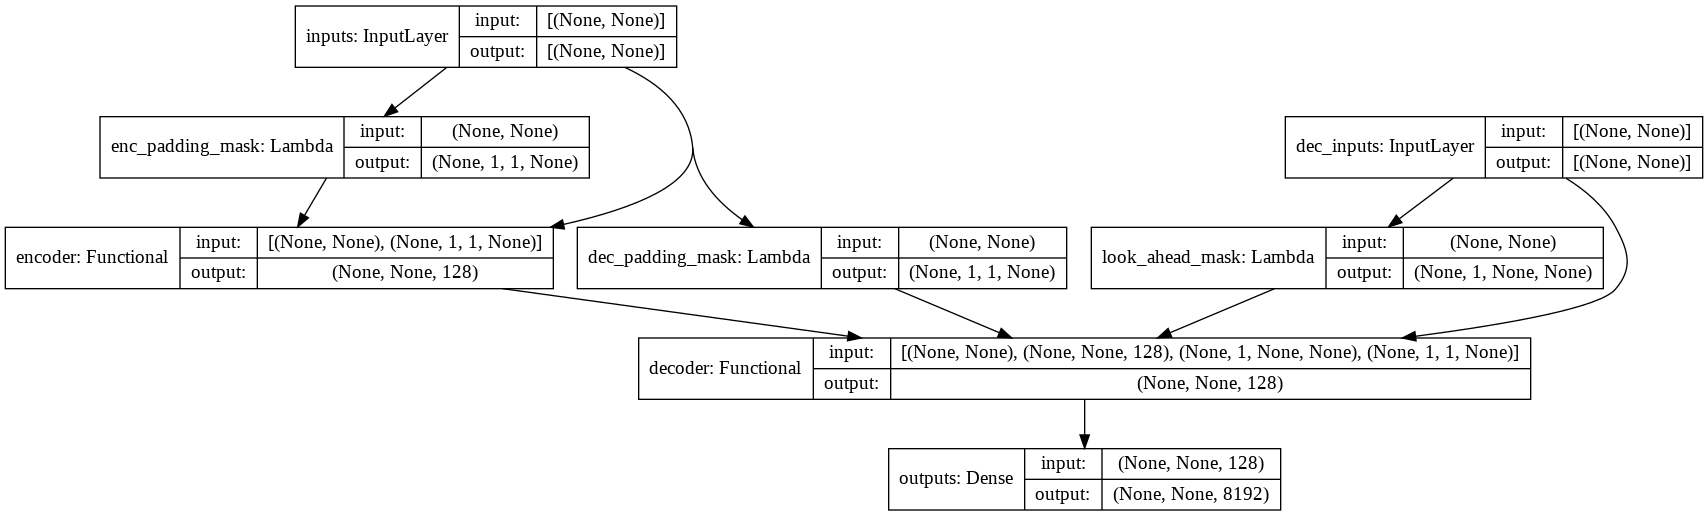

In [ ]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

## Train model

### Initialize model

To keep this example small and relatively fast, the values for *num_layers, d_model, and units* have been reduced. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2
# Create the model
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

### Loss function and accuracy metric

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss and accuracy.

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, SUMM_MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, SUMM_MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

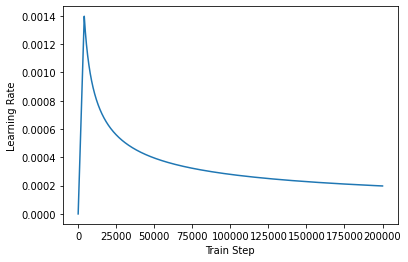

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Compile Model


In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## Create Callbacks for Checkpointing the model and apply early stop

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  save_weights_only=True,
                                                  verbose=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                               min_delta=0.0025, patience=3,
                                               restore_best_weights=True)

### Fit model

Train our transformer by simply calling `model.fit()`

In [ ]:
EPOCHS = 75

model.fit(dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[cp_callback, es_callback])

Epoch 1/75
855/855 [==============================] - 113s 120ms/step - loss: 1.7899 - accuracy: 0.0430 - val_loss: 1.0528 - val_accuracy: 0.1161

Epoch 00001: val_loss improved from inf to 1.05281, saving model to /content/drive/My Drive/Projects/SpainAI NLP/ckpt/ckpt_transformer
Epoch 2/75
855/855 [==============================] - 101s 119ms/step - loss: 0.9891 - accuracy: 0.1264 - val_loss: 0.6279 - val_accuracy: 0.1739

Epoch 00002: val_loss improved from 1.05281 to 0.62793, saving model to /content/drive/My Drive/Projects/SpainAI NLP/ckpt/ckpt_transformer
Epoch 3/75
855/855 [==============================] - 101s 118ms/step - loss: 0.6617 - accuracy: 0.1707 - val_loss: 0.4894 - val_accuracy: 0.1967

Epoch 00003: val_loss improved from 0.62793 to 0.48942, saving model to /content/drive/My Drive/Projects/SpainAI NLP/ckpt/ckpt_transformer
Epoch 4/75
855/855 [==============================] - 101s 118ms/step - loss: 0.5377 - accuracy: 0.1887 - val_loss: 0.4230 - val_accuracy: 0.2083


## Save the trained model

In [ ]:
savedmodel_path = os.path.abspath(os.path.join(model_path, 'transformer'))
model.save(savedmodel_path, include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Projects/SpainAI NLP/model/transformer/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Projects/SpainAI NLP/model/transformer/assets


## Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`. 
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

## Load the test dataset

In [ ]:
# Load the dataset
df_test=pd.read_csv(test_filenamepath, header=0)
print('Num Examples: ',len(df_test))
print('Null Values\n', df_test.isna().sum())

Num Examples:  1441
Null Values
 description    0
dtype: int64


In [ ]:
df_test.head()

,description
0,knit midi dress vneckline straps matching lace...
1,loosefitting dress round neckline long sleeves...
2,nautical cap peak.this item must returned orig...
3,nautical cap peak . adjustable inner strap det...
4,nautical cap side button detail.this item must...


## Inference or predict function 

To evaluate the performence  we calculate the Rouge Score metric for every prediction. 

In [ ]:
def evaluate_metric(val_enc_inputs, val_dec_outputs):

  rouge2=[]

  for enc_inputs, targets in zip(val_enc_inputs, val_dec_outputs):

      enc_inputs = tf.expand_dims(enc_inputs, axis=0)
      output = tf.expand_dims(START_TOKEN, 0)

      for i in range(SUMM_MAX_LENGTH):
        predictions = model(inputs=[enc_inputs, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
          break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

      output = tf.squeeze(output, axis=0)
      predicted_sentence = tokenizer.decode(
          [i for i in output if i < tokenizer.vocab_size])
      reference = tokenizer.decode(
          [i for i in targets if i < tokenizer.vocab_size])
      metric.add(prediction=predicted_sentence, reference=reference)

  # Calculate the rouge score for the epoch
  metric_results = metric.compute()
  metric_score = parse_score(metric_results)

  return metric_score

# Make a prediction for a text sample using the SubWord Tokenizer
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(SUMM_MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

# Make a prediction for a text sample using the Word Tokenizer
def evaluate_word_token(sentence):
  sentence = preprocess_sentence(sentence)
  sentence = '<start> ' + sentence + ' <end>'
  #sentence = tf.expand_dims(tokenizer.texts_to_sequences(['<start> '+sentence+' <end>']),0)
  input=[]
  for i in sentence.split(' '):
      if i in tokenizer.word_index:
          input.append(tokenizer.word_index[i] if tokenizer.word_index[i] < VOCAB_SIZE 
                        else tokenizer.word_index['<unk>'])

  input = pad_sequences([input], maxlen=TEXT_MAX_LENGTH, truncating='post',padding='post')
  sentence = tf.convert_to_tensor(input)

  output = tf.expand_dims([sos_token_output], 0)

  for i in range(SUMM_MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, eos_token_output):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

# 
def predict(sentence):
  if type_tokenizer=='word':
      prediction = evaluate_word_token(sentence)
      predicted_sentence = ' '.join([tokenizer.index_word[i] for i in prediction.numpy() if i>3])
      #predicted_sentence = tokenizer.sequences_to_texts([prediction])
  else: 
      prediction = evaluate(sentence)

      predicted_sentence = tokenizer.decode(
          [i for i in prediction if i < tokenizer.vocab_size])

  return predicted_sentence

## Generate output results

### Load the saved model

In [ ]:
del model

In [ ]:
savedmodel_path = os.path.abspath(os.path.join(model_path, 'transformer'))
model = tf.keras.models.load_model(savedmodel_path)
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3135232     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [ ]:
preprocess_sentence(df_test['description'].values[0])

'knit midi dress vneckline straps matching lace detail . height model . .'

In [ ]:
predictions=[]
for i,desc in enumerate(df_test['description'].values):
  predictions.append(predict(desc))
  if i%25 ==0:
    print('Lote ',i)


Lote  0
Lote  25
Lote  50
Lote  75
Lote  100
Lote  125
Lote  150
Lote  175
Lote  200
Lote  225
Lote  250
Lote  275
Lote  300
Lote  325
Lote  350
Lote  375
Lote  400
Lote  425
Lote  450
Lote  475
Lote  500
Lote  525
Lote  550
Lote  575
Lote  600
Lote  625
Lote  650
Lote  675
Lote  700
Lote  725
Lote  750
Lote  775
Lote  800
Lote  825
Lote  850
Lote  875
Lote  900
Lote  925
Lote  950
Lote  975
Lote  1000
Lote  1025
Lote  1050
Lote  1075
Lote  1100
Lote  1125
Lote  1150
Lote  1175
Lote  1200
Lote  1225
Lote  1250
Lote  1275
Lote  1300
Lote  1325
Lote  1350
Lote  1375
Lote  1400
Lote  1425


In [ ]:
df_test['name']=predictions
df_test.head(10)
df_test.to_csv(os.path.abspath(os.path.join(DATA_PATH, 'submission.csv')), sep=",",index=False,header=True, columns=['name'])

## Save Tokenizer for latter inference

We need to save the tokenizer in order to use the model in a future for make predictions on new data.

In [ ]:
# Save the tokenizers with the vocabularies
print('Saving the tokenizer ....')
tokenizer_path = os.path.join(output_path, 'tokenizer.pkl')
with open(tokenizer_path, 'wb') as f:
  pickle.dump(tokenizer, f)

Save the model's parameters

In [ ]:
# Save the parameters used to construct the model
print("Saving the model parameters")
model_info_path = os.path.join(output_path, 'model_info.pth')
with open(model_info_path, 'wb') as f:
    model_info = {
            'vocab_size_enc': num_words_inputs,
            'vocab_size_dec': num_words_output,
            'n_layers': NUM_LAYERS,
            'd_model': D_MODEL,
            'batch_size': BATCH_SIZE,
            'n_heads': NUM_HEADS,
            'ffn_units': UNITS,
            'dropout': DROPOUT,
            'epochs': EPOCHS,
            'text_max_len': TEXT_MAX_LENGTH,
            'summ_max_len': SUMM_MAX_LENGTH
    }
    pickle.dump(model_info, f)


Saving the model parameters
